In [1]:
import torch
from torch_geometric.datasets import TUDataset
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import *
from sklearn.metrics import roc_auc_score

## Introduction to the MUTAG Dataset

The **MUTAG** dataset consists of **188 nitro compounds** represented as molecular graphs. The goal of this dataset is to classify whether a compound is **aromatic** or **heteroaromatic**. Each molecule is represented as a graph where:

- **Nodes** represent atoms in the molecule.
- **Edges** represent bonds between atoms.

### Node Features:
Each node (atom) in the graph is labeled with a unique identifier corresponding to the type of atom. The following mapping is used for the node labels:

- **0**: Carbon (C)
- **1**: Nitrogen (N)
- **2**: Oxygen (O)
- **3**: Fluorine (F)
- **4**: Iodine (I)
- **5**: Chlorine (Cl)
- **6**: Bromine (Br)

These features allow the model to learn from the specific atomic composition of the molecules.

### Edge Features:
Each edge in the graph represents a bond between two atoms, with the following labels:

- **0**: Aromatic bond
- **1**: Single bond
- **2**: Double bond
- **3**: Triple bond

These bond types define the chemical structure of the molecules and play a significant role in determining the mutagenic effect on a bacterium.

### Task:
The MUTAG dataset is used for **binary classification**, where the goal is to classify the entire graph (molecule) as either **aromatic** or **heteroaromatic**. This classification is based on the molecular structure and the relationships between the atoms.

In the following code, we will explore the structure of the MUTAG dataset, extract features, and use it to train a GNN model for graph classification.

=== References ===

Debnath, A.K., Lopez de Compadre, R.L., Debnath, G., Shusterman, A.J., and Hansch, C.
Structure-activity relationship of mutagenic aromatic and heteroaromatic nitro compounds.
Correlation with molecular orbital energies and hydrophobicity. J. Med. Chem. 34(2):786-797 (1991).

In [2]:
dataset = TUDataset(root='../MolDataset/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/home/yurui/anaconda3/envs/gnn_tut/lib/python3.9/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.

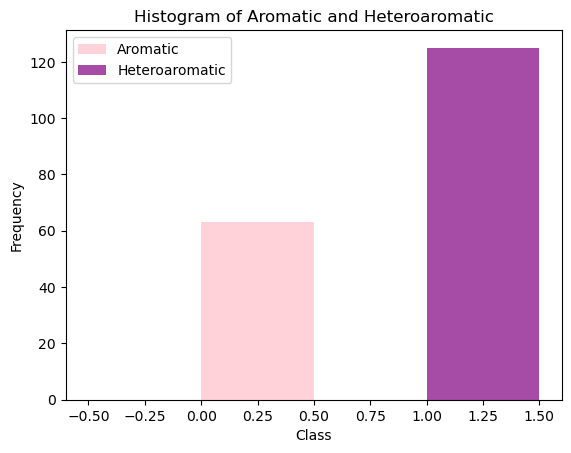

In [3]:
y_np = dataset.y.cpu().numpy()  # Convert to NumPy array if needed

y_zero = y_np[y_np == 0]
y_one = y_np[y_np == 1]

# Plot histograms for the two classes 0 and 1 with different colors and labels
plt.hist(y_zero, bins=dataset.num_classes, alpha=0.7, label='Aromatic', color='pink')
plt.hist(y_one, bins=dataset.num_classes, alpha=0.7, label='Heteroaromatic', color='purple')

# Add a legend
plt.legend(loc='upper left')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Aromatic and Heteroaromatic')

# Show the plot
plt.show()

In [4]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


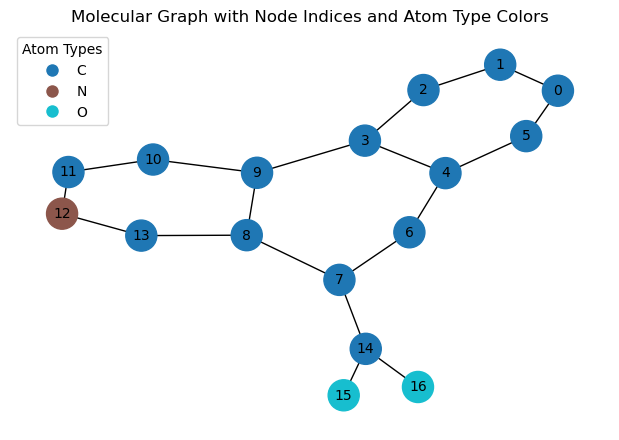

In [24]:
idx = 0
node_attr = dataset[idx].x.argmax(dim=-1)
node_attr = node_attr.numpy()
edge_list = dataset[idx].edge_index.T.tolist()
atomic_num_symbol_map_total = {0:'C',
 1:'N',
 2:'O',
 3:'F',
 4:'I',
 5:'Cl',
 6:'Br'}
unique_node_attr = np.unique(node_attr)
atomic_num_symbol_map = {k: atomic_num_symbol_map_total[k] for k in node_attr}
visualize_molecule_graph(edge_list, node_attr, atomic_num_symbol_map)

In [6]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_loader_eval = DataLoader(train_dataset, batch_size=64, shuffle=False)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



## Model Comparison: GCN (PyTorch Geometric), GCN (Custom Implementation), and GIN

In this section, we will compare the performance of three different Graph Neural Networks (GNNs) on the **MUTAG** dataset:
1. **GCN** - Graph Convolutional Network (from PyTorch Geometric implementation).
2. **GCN** - Our custom GCN implementation.
3. **GIN** - Graph Isomorphism Network.

Each of these models will be trained and evaluated on the MUTAG dataset. We will compare their performance based on metrics like **accuracy** and **AUC** (Area Under the Curve). The aim is to analyze how these different GNN architectures handle the task of graph classification and understand the strengths of each approach.

#### GCN Specification:

- **conv1**: First graph convolution layer that takes input node features and transforms them from dimension **7** to **64**.
- **conv2**: Second graph convolution layer that maintains a hidden dimension of **64**.
- **conv3**: Third graph convolution layer that maintains a hidden dimension of **64**.
- **pool**: global_mean_pool is applied to the nodes to get graph representation.
- **lin**: A fully connected linear layer that takes the output of the third convolution layer and maps it to **2** output classes (for binary classification).

Additionally, we apply **Dropout** with a probability of **0.5** after each graph convolutional layer to prevent overfitting.

Note, in `GCNConv`, the default `normalize` is set to `True`, and `add_self_loop` is automatically set to `True` under this condition.


In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool


class GCN_pyg(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_pyg, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x



The GCN model structure can be summarized as:

In [8]:
model = GCN_pyg(hidden_channels=64)
print(model)

GCN_pyg(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [9]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN_pyg(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
train_losses = []
test_aucs = []

def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)


def test(loader):
    model.eval()
    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        correct = 0
        for data in loader:  # Iterate in batches over the testing dataset.
            out = model(data.x, data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.

            # Store true labels and predicted probabilities for AUC calculation
            true_labels.extend(data.y.cpu().numpy())
            predicted_probs.extend(out.softmax(dim=1)[:, 1].cpu().numpy())  # Probability of the positive class

    # Calculate accuracy
    accuracy = correct / len(loader.dataset)

    # Calculate AUC if there are at least two classes
    if len(set(true_labels)) > 1:
        auc = roc_auc_score(true_labels, predicted_probs)
    else:
        auc = 0.5  # Assign AUC of 0.5 if only one class is present

    return accuracy, auc, true_labels, predicted_probs

for epoch in range(1, 101):
    train_loss = train()  # Train and get the training loss
    train_acc, _, _, _ = test(train_loader)  # Get training accuracy
    test_acc, test_auc, y_true, y_pred_gcn_pyg = test(test_loader)  # Get test accuracy and AUC

    # Store the training loss and test AUC
    train_losses.append(train_loss)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}')

train_acc, train_auc, y_true_train, y_pred_train_gcn_pyg = test(train_loader_eval)


<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 0.6856, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8393
Epoch: 002, Train Loss: 0.6763, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8357
Epoch: 003, Train Loss: 0.6659, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8393
Epoch: 004, Train Loss: 0.6593, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8357
Epoch: 005, Train Loss: 0.6518, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8321
Epoch: 006, Train Loss: 0.6495, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 007, Train Loss: 0.6278, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8250
Epoch: 008, Train Loss: 0.6412, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 009, Train Loss: 0.6334, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 010, Train Loss: 0.6367, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 011, Train Loss: 0.6469, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8321
Epoch: 012, Train Loss: 0.6471, Train Acc: 0.6467, Tes

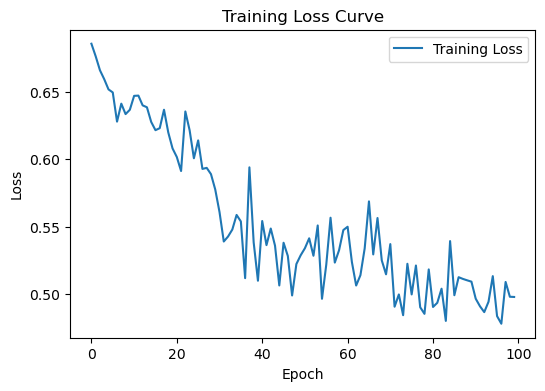

In [10]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

### Check with the self-defined GCN model

In [11]:
from Model.layers import GCNLayer
from torch_geometric.utils import add_self_loops


In [12]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_channels, out_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_dim)
    def forward(self, x, edge_index, batch):
        edge_index = add_self_loops(edge_index)[0]
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [13]:
model = GCN(in_dim = dataset.num_node_features ,hidden_channels=64, out_dim=dataset.num_classes)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [14]:
model = GCN(in_dim = dataset.num_node_features ,hidden_channels=64, out_dim=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
train_losses = []
test_aucs = []
for epoch in range(1, 101):
    train_loss = train()  # Train and get the training loss
    train_acc, _, __, ___ = test(train_loader)  # Get training accuracy
    test_acc, test_auc, y_true, y_pred_gcn = test(test_loader)  # Get test accuracy and AUC

    # Store the training loss and test AUC
    train_losses.append(train_loss)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}')

train_acc, train_auc, y_true_train, y_pred_train_gcn = test(train_loader_eval)

Epoch: 001, Train Loss: 0.6912, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.1893
Epoch: 002, Train Loss: 0.6784, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.7786
Epoch: 003, Train Loss: 0.6593, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8357
Epoch: 004, Train Loss: 0.6531, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8214
Epoch: 005, Train Loss: 0.6508, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8250
Epoch: 006, Train Loss: 0.6386, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8250
Epoch: 007, Train Loss: 0.6441, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 008, Train Loss: 0.6341, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8286
Epoch: 009, Train Loss: 0.6233, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8214
Epoch: 010, Train Loss: 0.6431, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8214
Epoch: 011, Train Loss: 0.6401, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8179
Epoch: 012, Train Loss: 0.6471, Train Acc: 0.6467, Tes

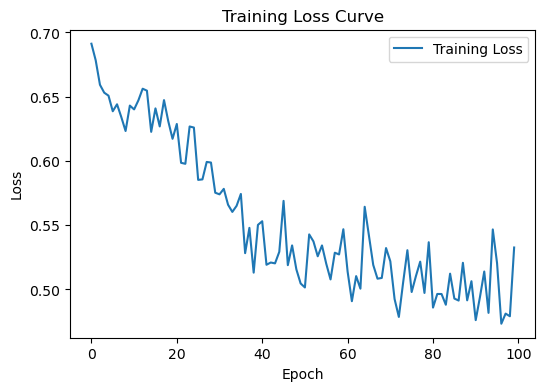

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()


### GIN Architecture

The **Graph Isomorphism Network (GIN)** is a more powerful GNN variant designed to better capture the structural properties of graphs. It is based on the **Weisfeiler-Lehman (WL) test for graph isomorphism**, a powerful heuristic for determining whether two graphs are structurally identical.

#### GIN Update Rule:

At each layer, the GIN updates the feature vector of each node based on the following operation:

$$
h_v^{(k)} = \text{MLP}^{(k)} \left( \left( 1 + \epsilon^{(k)} \right) \cdot h_v^{(k-1)} + \sum_{u \in \mathcal{N}(v)} h_u^{(k-1)} \right)
$$
Where:
- $h_v^{(k)}$ represents the feature vector of node $v$ at layer $k$.
- $\mathcal{N}(v)$ is the set of neighbors of node $v$.
- $\text{MLP}^{(k)}$ is a Multi-Layer Perceptron applied at layer $k$.
- $\epsilon^{(k)}$ is a learnable parameter that controls the balance between the node’s self-information and its neighbors’ information.


In the following sections, we will implement, train, and compare the performance of these models on the MUTAG dataset.



In [16]:
from torch_geometric.nn import MLP, GINConv, global_add_pool


class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            in_channels = hidden_channels
        self.mlp = MLP([hidden_channels, hidden_channels, out_channels],
                       norm=None, dropout=0.5)
    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        x = global_add_pool(x, batch)
        return self.mlp(x)



In [17]:
model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=3,
)
print(model)

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(7, 32, 32))
    (1-2): 2 x GINConv(nn=MLP(32, 32, 32))
  )
  (mlp): MLP(32, 32, 2)
)


In [18]:

model = GIN(
    in_channels=dataset.num_features,
    hidden_channels=32,
    out_channels=dataset.num_classes,
    num_layers=3,
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
test_aucs = []

for epoch in range(1, 71):
    train_loss = train()  # Train and get the training loss
    train_acc, _, __, ___ = test(train_loader)  # Get training accuracy
    test_acc, test_auc, y_true, y_pred_gin = test(test_loader)  # Get test accuracy and AUC

    # Store the training loss and test AUC
    train_losses.append(train_loss)
    test_aucs.append(test_auc)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}')
train_acc, train_auc, y_true_train, y_pred_train_gin = test(train_loader_eval)

Epoch: 001, Train Loss: 0.7485, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.9107
Epoch: 002, Train Loss: 0.5586, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.8929
Epoch: 003, Train Loss: 0.4566, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.9000
Epoch: 004, Train Loss: 0.3811, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.9214
Epoch: 005, Train Loss: 0.3767, Train Acc: 0.6467, Test Acc: 0.7368, Test AUC: 0.9321
Epoch: 006, Train Loss: 0.4404, Train Acc: 0.6733, Test Acc: 0.7368, Test AUC: 0.9232
Epoch: 007, Train Loss: 0.3805, Train Acc: 0.7067, Test Acc: 0.8158, Test AUC: 0.9321
Epoch: 008, Train Loss: 0.2967, Train Acc: 0.7400, Test Acc: 0.7895, Test AUC: 0.9214
Epoch: 009, Train Loss: 0.3575, Train Acc: 0.7733, Test Acc: 0.8158, Test AUC: 0.9286
Epoch: 010, Train Loss: 0.3474, Train Acc: 0.7933, Test Acc: 0.8421, Test AUC: 0.9286
Epoch: 011, Train Loss: 0.3553, Train Acc: 0.8467, Test Acc: 0.8158, Test AUC: 0.9179
Epoch: 012, Train Loss: 0.3405, Train Acc: 0.8000, Tes

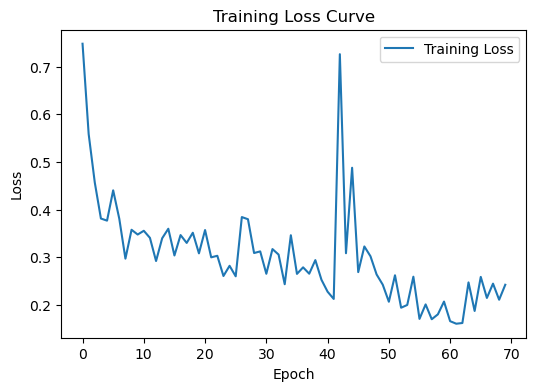

In [19]:
plt.figure(figsize=(6, 4))

plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [20]:
## Draw the AUC curve from sklearn
from sklearn.metrics import roc_curve
fpr_gcn_pyg, tpr_gcn_pyg, _ = roc_curve(y_true, y_pred_gcn_pyg)
AUC_gcn_pyg = roc_auc_score(y_true, y_pred_gcn_pyg)
fpr_gcn, tpr_gcn, _ = roc_curve(y_true, y_pred_gcn)
AUC_gcn = roc_auc_score(y_true, y_pred_gcn)
fpr_gin, tpr_gin, _ = roc_curve(y_true, y_pred_gin)
AUC_gin = roc_auc_score(y_true, y_pred_gin)
## For the train AUC
fpr_gcn_pyg_train, tpr_gcn_pyg_train, _ = roc_curve(y_true_train, y_pred_train_gcn_pyg)
fpr_gcn_train, tpr_gcn_train, _ = roc_curve(y_true_train, y_pred_train_gcn)
fpr_gin_train, tpr_gin_train, _ = roc_curve(y_true_train, y_pred_train_gin)


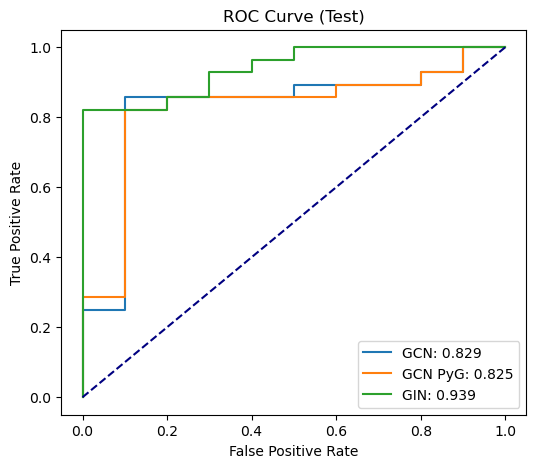

In [21]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_gcn, tpr_gcn, label=f"GCN: {AUC_gcn:.3f}")
plt.plot(fpr_gcn_pyg, tpr_gcn_pyg, label=f"GCN PyG: {AUC_gcn_pyg:.3f}")
plt.plot(fpr_gin, tpr_gin, label=f"GIN: {AUC_gin:.3f}")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend()

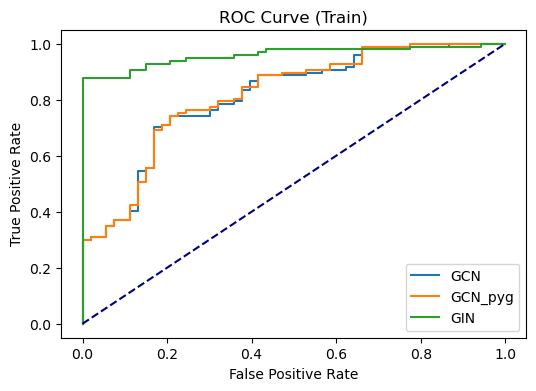

In [22]:
## Plot for the train AUC
plt.figure(figsize=(6, 4))
plt.plot(fpr_gcn_train, tpr_gcn_train, label='GCN')
plt.plot(fpr_gcn_pyg_train, tpr_gcn_pyg_train, label='GCN_pyg')
plt.plot(fpr_gin_train, tpr_gin_train, label='GIN')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train)')
plt.legend()